In [163]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

# Defining the problem

We define a domain $\Omega$ of length $L$ from $x_0$ to $x_1$ and height $h$ from $y_0$ to $y_1$

This domain is discretized in a structured fashion with $n_x$ and $n_y$ point in respectively, the $x$ and $y$ directions

On this domain we solve the stationnary incompressible boundary layer equations for an initial uniform flow $u(x,t_0)$ and a set of well defined boundary conditions $\Gamma$.

The equations are given as a continuity equation for an incompressible flow $(\nabla.\pmb u=0)$, with $\pmb u = (u,v)$ the velocity vector :
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

And a momentum conservation equation within the boundary layer :

$$u\frac{\partial u}{\partial x} + u\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu \frac{\partial^2 u}{\partial y^2}$$

Note the pressure gradient contribution $-\frac{1}{\rho}\frac{\partial p}{\partial x}$ that drives the velocity gradients distribution within the boundary layer.

## Defining the discretization

(0.0001669449081803005, 0.0002512562814070352)

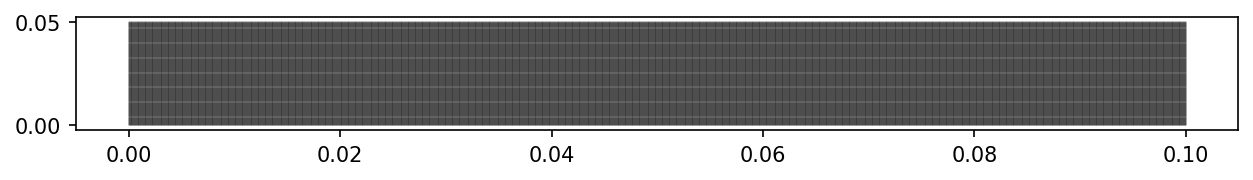

In [203]:
nx = 600
ny = 200

x_0 = 0.0
x_1 = 0.1
y_0 = 0.0
y_1 = 5e-2

x = np.linspace(x_0, x_1, nx)
y = np.linspace(y_0, y_1, ny)

dx = np.diff(x)[0]
dy = np.diff(y)[0]

X,Y = np.meshgrid(x,y, indexing ='ij')

plt.figure(figsize = (10,1), dpi = 150)
plt.plot(X,Y, color='k', linewidth = 0.2);
plt.plot(X.T,Y.T, color='k', linewidth = 0.2);

dx, dy

## Creating an initial condition and a set of boundary conditions

In [220]:
#Current arrays
u = np.ones((nx,ny), dtype = np.float32)
v = np.zeros((nx,ny), dtype = np.float32)

# Updated arrays
u_n = np.ones((nx,ny), dtype = np.float32)
v_n = np.zeros((nx,ny), dtype = np.float32)

#BC
u[:,0] = 0.0
u_n[:,0] = 0.0
#Viscosity
nu = 1.7e-5


## Solving the discretized PDEs with an explicit method

In [221]:
@jit(nopython=True, parallel=False)
def compute (u,v, u_n, v_n):
    for i in prange(0, nx-1):
        for j in prange(1, ny-1):

            u_n[i+1,j] = u[i,j] - (v[i,j]*dx)/(u[i,j]*dy)*(u[i,j]-u[i,j-1])+(nu*dx)/(u[i,j]*dy**2)*(u[i,j+1]-2*u[i,j]+u[i,j-1])

            v_n[i+1,j] = v[i+1,j-1]-(dx/dy)*(u_n[i+1,j]-u_n[i,j])

            u[i+1,j] = u_n[i+1,j]
            v[i+1,j] = v_n[i+1,j]

        CFL = (v[i,j]*dx)/(u[i,j]*dy)
    
    return u,v

u,v = compute (u,v, u_n, v_n)

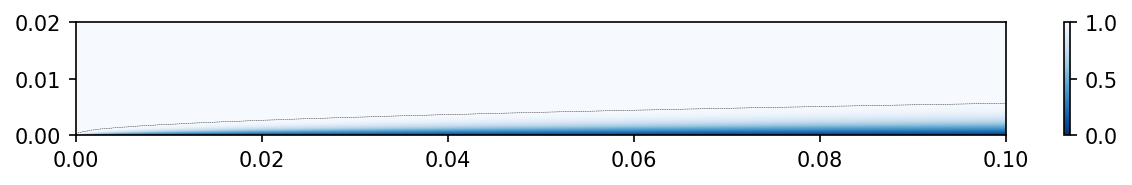

In [247]:

plt.figure(figsize=(10,1), dpi=150)
cmap = plt.cm.Blues_r
c = plt.contourf(X,Y,u, 
                 levels = 128, 
                 cmap = cmap)
plt.contour(X, Y, u, 
            levels=[0,0.99], 
            colors = 'k', 
            linewidths = 0.2, 
            linestyles='--')
plt.ylim(0,2e-2)
cbar = plt.colorbar(c, ticks=[0.0, 0.5, 1.0])

(0, 0.03)

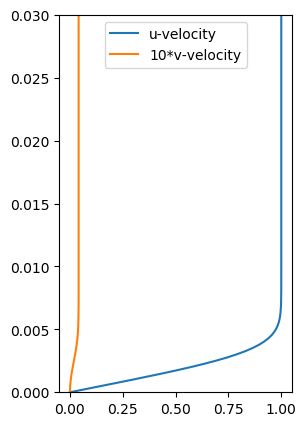

In [246]:
plt.figure(figsize=(3,5), dpi=100)
plt.plot(u[-1,:],Y[-1,:], label='u-velocity')
plt.plot(10*v[-1,:],Y[-1,:], label='10*v-velocity')
plt.legend()
plt.ylim(0,3e-2)